# **MO436 - Project 1 - Pokémon RL**

## **Group:**

* Bruno César de Oliveira Souza - 234837

* Henrique Lima Cará de Oliveira - 091518

* Leonardo de Lellis Rossi - 261900

* Maurício Pereira Lopes - 225242

[Git Repository](https://github.com/leolellisr/poke_RL)

[Graphs MC Control, MC Control FA, Q-Learning, Q-Learning FA, SARSA($\lambda$) Deterministic and SARSA($\lambda$) FA](https://app.neptune.ai/leolellisr/rl-pokeenv)

[Graphs SARSA($\lambda$) Stochastic](https://app.neptune.ai/mauricioplopes/poke-env)

Images and results are showed with IFrame from IPython.display, but it needs the images stored in the /images/report folder, available in our [git repository](https://github.com/leolellisr/poke_RL). 

Images and Results also are presented with links from LightShot and imgur, that don't need files.

In [1]:
from IPython.display import IFrame

# Goal and Motivation

* This project aims to employ different reinforcement learning techniques to train agents in a Pokémon battle simulator;

* Our motivation is that the trainer automatically learns, by making decisions through the analysis of states and rewards related to their performance, how to win battles throughout the episodes, noticing:
  * the different types between Pokémon;
  * which moves cause more damage to the opponent's Pokémon;
  * what are the possible strategies using no-damage moves;
  * and the best times to switch Pokémon. 

## **The  problem addressed**
* [Pokémon](https://www.pokemon.com) is a popular Japanese RPG (Role Playing Game) which stands a world championship every year; 
* One single [battle](https://bulbapedia.bulbagarden.net/wiki/Pokémon_battle) of Pokémon has two players. Each player has a 6-Pokémon team; 
* Each Pokémon has:
 * 6 [stats](https://bulbapedia.bulbagarden.net/wiki/Stat) (Health Points, Attack, Defense, Special Attack, Special Defense, Speed). The first 5 are used in the damage calculation. The speed defined which Pokémon moves first in the turn.
  * The Health Points goes from 100% (healthy) to 0% (fainted);
 * 4 possible moves (each with a limited number of uses). Each move has an accuracy, a percentage of success or fail;
 * one [ability](https://bulbapedia.bulbagarden.net/wiki/Ability) that has special effects in the field;
 * one [nature](https://bulbapedia.bulbagarden.net/wiki/Nature) that specifies which stats are higher and which are lower;
 * one [item](https://bulbapedia.bulbagarden.net/wiki/Item), that can  restore Health Points or increase the Power of an Attack.
* The winner of the battle is the player that makes all Pokémon of the oposing team to faint (all oposing Pokémon with health points equals zero, "last man standing" criteria);
* Only one Pokémon of each team can be at the battle field at the same time;
* Every turn, each players select one action: one of the 4 moves of their active Pokémon or [switching](https://bulbapedia.bulbagarden.net/wiki/Recall) for one of other non-fainted Pokémon of their team;

* Pokémon can be summarized as an analyze state (turn) -> take action sequence game. 

* By standard, Pokémon is a stochastic game:
 * One move can have an accuracy value less than 100%, then this move has a probability to be missed;
 * The damage moves (attacks) have the following [damage calculation](https://bulbapedia.bulbagarden.net/wiki/Damage):
  ![Damage](https://wikimedia.org/api/rest_v1/media/math/render/svg/b8c51fed93bb9a80ae8febc13700a40b8a5da402)
  
 where:
  * **[Level](https://bulbapedia.bulbagarden.net/wiki/Level)** (the level of the attacking Pokémon);
  * **A** is the effective Attack stat of the attacking Pokémon if the used move is a physical move, or the effective Special Attack stat of the attacking Pokémon if the used move is a special move;
  * **D** is the effective Defense stat of the target if the used move is a physical move or a special move that uses the target's Defense stat, or the effective Special Defense of the target if the used move is an other special move;
  * **[Power](https://bulbapedia.bulbagarden.net/wiki/Power)** is the effective power of the used move;
  * **Weather** is 1.5 if a Water-type move is being used during rain or a Fire-type move during harsh sunlight, and 0.5 if a Water-type move is used during harsh sunlight or a Fire-type move during rain, and 1 otherwise.
  * **[Critical](https://bulbapedia.bulbagarden.net/wiki/Critical_hit)** has 6.25% chance of occurs and multiplies the damage by 1.5;
  * **random** is a random factor between 0.85 and 1.00 (inclusive):
  * **[STAB](https://bulbapedia.bulbagarden.net/wiki/Same-type_attack_bonus)** is the same-type attack bonus. This is equal to 1.5 if the move's type matches any of the user's types, 2 if the user of the move additionally has the ability Adaptability, and 1 if otherwise;
  * **[Type](https://bulbapedia.bulbagarden.net/wiki/Type)** is the type effectiveness. This can be 0 (ineffective); 0.25, 0.5 (not very effective); 1 (normally effective); 2, or 4 (super effective), depending on both the move's and target's types;
  * **[Burn](https://bulbapedia.bulbagarden.net/wiki/Burn_(status_condition))** is 0.5 (from Generation III onward) if the attacker is burned, its Ability is not Guts, and the used move is a physical move (other than Facade from Generation VI onward), and 1 otherwise.
  * **other** is 1 in most cases, and a different multiplier when specific interactions of moves, Abilities, or items take effect. In this work, this is applied just to Pokémon that has the item **Life Orb**, which multiplies the damage by 1.3.
  
  * **Not** used in this work (equals 1):
   * Targets (for Battles with more than two active Pokémon in the field);
   * Badge ( just applied in Generation II);
   
   

# **MDP formulation and discretization model** 

## Original (stochastic)

We considered our original (stochastic) MDP as a tuple $M = (S, A, \phi, R)$, where:
* **S** is the whole set of possible states. One state **s $\in$ S**  is defined at each turn with 12 battle elements concatenated, that correspond to:
 * [0] Our Active Pokémon index (0: Venusaur,  1: Pikachu, 2: Tauros, 3: Sirfetch'd, 4: Blastoise, 5: Charizard);
 * [1] Opponent Active Pokémon index (0: Eevee,  1: Vaporeon, 2: Leafeon, 3: Sylveon, 4: Jolteon, 5: Umbreon);
 * [2-5] Active Pokémon moves base power (if a move doesn't have base power, default to -1);
 * [6-9] Active Pokémon moves damage multipliers;
 * [10] Our remaining Pokémon;
 * [11] Opponent remaining Pokémon.
 
* **A** is the whole set of possible actions. Our action space is a range [0, 8]. One action **a $\in$ A** is one of the possible choices:
 * [0] 1st Active Pokémon move;
 * [1] 2nd Active Pokémon move;
 * [2] 3rd Active Pokémon move;
 * [3] 4th Active Pokémon move;
 * [4] Switch to 1st next Pokémon;
 * [5] Switch to 2nd next Pokémon;
 * [6] Switch to 3rd next Pokémon;
 * [7] Switch to 4th next Pokémon;
 * [8] Switch to 5th next Pokémon.

When a selected action cannot be executed, we random select another possible action.

* **$\phi$** is a stochastic transition function that occurs from state **s** to state **s'**, by taking an action **a**. The following parameters are part of our  stochastic transition function:
 * Move's accuracy (chance of the move successfully occurs or fail);
 * Damage calculation: The **[Critical](https://bulbapedia.bulbagarden.net/wiki/Critical_hit)** parameter (6.25% chance of occurs) and the **random** parameter, ranging from 0.85 and 1.00 (inclusive).
 * Move's effects: Some moves have [additional effects](https://bulbapedia.bulbagarden.net/wiki/Additional_effect). e.g.: Iron Head have 30% chance of flinching the target (target cannot move in the turn).

* **R** is a set of rewards. A reward **r $\in$ R** is acquired in state **s** by taking the action **a**. The rewards are calculated at the end of the turn. The value of reward **r** is defined by the sum of elements:
 * +Our Active Pokémon current Health Points;
 * -2 if our Active Pokémon fainted;
 * -1 if our Active Pokémon have a [negative status condition](https://bulbapedia.bulbagarden.net/wiki/Status_condition);
 * +Number of remaining Pokémon in our team;
 * -Opponent Active Pokémon current Health Points;
 * +2 if opponent Active Pokémon fainted;
 * +1 if opponent Active Pokémon have a [negative status condition](https://bulbapedia.bulbagarden.net/wiki/Status_condition);
 * -Number of remaining Pokémon in opponent team;
 * +15 if we won the battle;
 * -15 if we lost the battle.
 
### Stochastic Team

Our stochastic team, with each Pokémon, their abilities, natures, items, moves (base power and accuracy) and possible switches are shown in [Team](https://prnt.sc/1y73c3t).


In [2]:
IFrame("images/report/Team stochastic.png", width=1000, height=600)

## Deterministic

To adapt Pokémon to a deterministic environment, we use Pokémon that cannot receive a critical hit, moves with only 100% accuracy and no side effects, and edit the server code to ignore the random parameter in damage calculation, removing the stochastic transition function $\phi$ from our MDP. Therefore, now our MDP is a tuple $M = (S, A, R)$, where:
* **S** is the whole set of possible states. One state **s $\in$ S**  is defined at each turn with 12 battle elements concatenated, that correspond to:
 * [0] Our Active Pokémon index ;
 * [1] Opponent Active Pokémon index ;
 * [2-5] Active Pokémon moves base power (if a move doesn't have base power, default to -1);
 * [6-9] Active Pokémon moves damage multipliers;
 * [10] Our remaining Pokémon;
 * [11] Opponent remaining Pokémon.
 
* **A** is the whole set of possible actions. Our action space is a range [0, 8] (len: 9). One action **a $\in$ A** is one of the possible choices:
 * [0] 1st Active Pokémon move;
 * [1] 2nd Active Pokémon move;
 * [2] 3rd Active Pokémon move;
 * [3] 4th Active Pokémon move;
 * [4] Switch to 1st next Pokémon;
 * [5] Switch to 2nd next Pokémon;
 * [6] Switch to 3rd next Pokémon;
 * [7] Switch to 4th next Pokémon;
 * [8] Switch to 5th next Pokémon.

When a selected action cannot be executed, we random select another possible action.

* **R** is a set of rewards. A reward **r $\in$ R** is acquired in state **s** by taking the action **a**. The rewards are calculated at the end of each turn. The value of reward **r** is defined by the sum of elements:
 * +Our Active Pokémon current Health Points;
 * -2 if our Active Pokémon fainted;
 * -1 if our Active Pokémon have a [negative status condition](https://bulbapedia.bulbagarden.net/wiki/Status_condition);
 * +Number of remaining Pokémon in our team;
 * -Opponent Active Pokémon current Health Points;
 * +2 if opponent Active Pokémon fainted;
 * +1 if opponent Active Pokémon have a [negative status condition](https://bulbapedia.bulbagarden.net/wiki/Status_condition);
 * -Number of remaining Pokémon in opponent team;
 * +15 if we won the battle;
 * -15 if we lost the battle.
 
### Deterministic Team

Our deterministic team, with each Pokémon, their abilities, natures, items, moves (base power and accuracy) and possible switches are shown in [Team](https://prnt.sc/1ydn52l).

We use on both teams only Pokémon with Battle Armor or Shell Armor abilities, which prevent critical hits from being performed. Also, we use in both teams only moves with 100% accuracy, with no chance of getting it missed, and the moves haven't additional effects.

In [3]:
IFrame("images/report/Team deterministic.png", width=1000, height=600)

## Search space

The features that integrate our states are shown in [this figure](https://prnt.sc/1yfksfe) and below. For a single battle between two players with 6 Pokémon each, we have $1.016.064$ possible states.

Since we have 9 possible actions, we total $9.144.576$ possibilities for each battle.

In [4]:
IFrame("images/report/possible_states.png", width=920, height=600)

# **The environments built**

The environment used is [Pokémon Showdown](https://play.pokemonshowdown.com), an [open-source](https://github.com/smogon/pokemon-showdown.git) Pokémon battle simulator.

[Example](https://prnt.sc/1ydofwv) of one battle in Pokémon Showdown.


In [5]:
IFrame("images/report/showdownEx.jpg", width=1000, height=1000)

To communicate our agents with Pokémon Showdown we used [poke-env](https://poke-env.readthedocs.io/en/latest/) a Python environment for interacting in Pokémon Showdown battles.

We used separated Python classes (available in our [git repository](https://github.com/leolellisr/poke_RL/tree/master/src)) for define the Players that are trained with each method. These classes communicates with Pokémon Showdown and implements the poke-env methods to:
* Create battles;
* Accept battles;
* Send orders (actions) to Pokémon Showdown.

## Original (stochastic)

To speed up the battles, we hosted our own server of Pokemon Showdown in localhost. It requires Node.js v10+.

In [ ]:
git clone https://github.com/smogon/pokemon-showdown.git

After clone the repository, it's needed to create a logs folder in root.

To configure the server, we used the following code:

In [ ]:
cd pokemon-showdown
npm install
cp config/config-example.js config/config.js

To start the server, we use:

In [ ]:
node pokemon-showdown start --no-security

## Deterministic environment

To adapt our environment to a deterministic setup, we had to establish the following parameters:

* We removed the random component of sim/battle.ts from the Pokémon Showdown simulator;

* We use on both teams only Pokémon with Battle Armor or Shell Armor abilities, which prevent critical hits from being performed;

* We used in both teams only moves with 100% accuracy, with no chance of getting it missed;

* We didn't use any move with additional effect. 

# **Characteristics of  the problem**

* Both of our environments (stochastic and deterministic) are episodic. One state occurs after another;

* Our terminal states are:
 * When all our Pokémon are fainted (we lose);
 * When all opponent Pokémon are fainted (we won).

* As specified before, a reward **r** is calculated at the end of a turn (beginning of next turn). The value of reward **r** is defined by the sum of:
 * +Our Active Pokémon current Health Points;
 * -2 if our Active Pokémon fainted;
 * -1 if our Active Pokémon have a [negative status condition](https://bulbapedia.bulbagarden.net/wiki/Status_condition);
 * +Number of remaining Pokémon in our team;
 * -Opponent Active Pokémon current Health Points;
 * +2 if opponent Active Pokémon fainted;
 * +1 if opponent Active Pokémon have a [negative status condition](https://bulbapedia.bulbagarden.net/wiki/Status_condition);
 * -Number of remaining Pokémon in opponent team;
 * +15 if we won the battle;
 * -15 if we lost the battle.

# **Monte Carlo Control**

We implemented Monte Carlo Control First Visit. 

* We defined 2 defaultDicts, $Q(s,a)$ and $N(s,a)$, to store the value function and the number of occurences of action **a** in state **s**, respectively. Both of them are initialized to zero;
 * Each dict has the keys as the states **s**;
 * The value of a key is an array of the len of action space (len: 9);
 * Each value of an array corresponds to an action in our action space;

* We used a step-size of $\alpha = 1/N[s,a]$;

* In the first move of a turn, we choose a random action;

* We used an $\epsilon$-greedy exploration strategy with $\epsilon = N0/(N0+N[s,:])$. We tested with 3 values for $N0: $ {$10^{-4}$, $10^{-3}$ and $10^{-2}$};

* We used the following $\epsilon$-greedy policy:

In [ ]:
def epsilon_greedy_policy(Q, n0, N):
    def policy_fn(state):
        dimension = Q[state].shape
        greedy_action = np.argmax(Q[state])
        epsilon = n0/(n0+np.sum(N[state]))
        probabilities = np.full(dimension, epsilon / dimension[0])
        probabilities[greedy_action] += 1 - epsilon
        return probabilities
    return policy_fn

* In each turn, we collect our observations to define our state with the embed battle function, getting the 12 battle elements concatenated. The state is converted to a string, that is used as a key to our defaultDicts $Q(s,a)$ and $S(s,a)$;
 
* With the state, we select an action using our policy and send it to Showdown;

* We store the state and selected action to append to an episode array in the next turn with the computed reward;

* At the end of the battle, $Q(s,a)$ and $N(s,a)$ are updated for the first time of each state seen in that battle:
 * $N(s,a)$ is increased by 1 for each action performed in a particular state;
 * The value of $Q(s,a)$ is summed to $\alpha*(G(t)-Q(s,a))$;
 * The return $G(t)$ is given by $ \sum \limits _{i=0} ^{T-1} \gamma^iR(t)$. We used $\gamma = 0,75$;
 * Our policy is then updated with the new values of $Q(s,a)$ and $N(s,a)$;



In [ ]:
rewards = [reward for state,action,reward in self.episode]
states = [state for state,action,reward in self.episode]
actions = [action for state,action,reward in self.episode]
t_array = range(len(self.episode)+1)
        
# Computing Q and N
for idx, state in enumerate(states):
    action = actions[idx]
    if state not in self.visited_states:
        self.N[state][action] += 1
        returnGt = sum([reward*pow(self.gamma, t) for reward, t in zip(rewards[idx:], t_array[:(-idx-1)])]) 

        # incremental update of Q value is more efficient than keeping a record of all rewards
        # and averaging after every new reward
        # step-size: 1./N[state][action]
                
        self.Q[state][action] += (1/self.N[state][action])*(returnGt-self.Q[state][action]) 
        self.visited_states.append(state)
                
self.visited_states = []
self.episode = []
# Define new policy with updated Q and N
self.policy = self.update_epsilon_greedy_policy(self.Q, self.n0, self.N)

* We trained our agent against a MaxDamagePlayer, that always selects the move with the greatest base power. We trained for $10.000$ battles. At the end, we saved $Q$ and $N$ in json files to future use.

* We validate our solution against a MaxDamagePlayer and against a RandomPlayer, that selects random actions at each turn. We validated for $3.333$ battles against each Player.  

## MC_Control - Stochastic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-84/dashboard/Compara-es-464d2bfc-e396-4bbd-b8bc-3cf9fe90b55e. 

### MC_Control - Stochastic - Rewards (per step) - Training 

[MC_Control - Stochastic - Rewards (per step) - Training](https://prnt.sc/1ycoapc)

In [6]:
IFrame("images/report/reward_computed_MC_Control.png", width=800, height=600)

### MC_Control - Stochastic - Win percentages (per step) - Training
[ MC_Control - Stochastic - Win percentages (per step) - Training](https://prnt.sc/1ycojai)

In [7]:
IFrame("images/report/win_acc_MC_Control.png", width=1000, height=600)

### MC_Control - Stochastic - Win percentages - Validation

### Versus MaxPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $1262/3333$ battles [this is $37.86\%$ and took $743.18$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $1063/3333$ battles [this is $31.89\%$ and took $743.37$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $1166/3333$ battles [this is $34.98\%$ and took $622.97$ seconds]

### Versus RandomPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $3026/3333$ battles [this is $90.79\%$ and took $841.88$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $3113/3333$ battles [this is $93.4\%$ and took $825.55$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $3130/3333$ battles [this is $93.91\%$ and took $762.68$ seconds]


### MC_Control - Stochastic - Memory and CPU usage (absolute time) - Training

[MC_Control - Stochastic - Memory and CPU usage (absolute time) - Training](https://prnt.sc/1ycopro)

In [8]:
IFrame("images/report/cpu and memory MC_Control.png", width=1000, height=600)


### MC_Control - Stochastic - Value Function $V^*(s)$ 

We defined two Value Functions to demonstrate the performance of our agents. 

The first one considers in its Y axis the difference between the number of our remaining Pokémon and the number of remaining Pokémon of the opponent. On its X axis the function uses the Index of our active Pokémon in the field multiplided by 20 in a sum with the sum of the base powers moves multiplied by their respective multipliers.

$y = $ our_remaining_Pokémon - opponents_remaining_Pokémon

$x = $ index_our_activePokémon$*20 + \sum \limits _{i=1} ^{4}$ move_base_power$[i]*$move_damage_multiplier$[i]$ 

We observed that the sum of the base powers moves multiplied by their respective multipliers is always a value between -10 and 10. Therefore, we can divide the following ranges to each of our Pokémon in X axis:

$[-10, 10]:$ Venosaur

$[10, 30]:$ Pikachu

$[30, 50]:$ Taurus

$[50, 70]:$ Sirfetch'd

$[70, 90]:$ Blastoise

$[90, 110]:$ Charizard

### MC_Control - Stochastic - Value Function $V^*_1(s)$

[MC_Control - Stochastic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.0001 - gamma: 0.75](https://prnt.sc/1yjr8v3)

In [9]:
IFrame("images/vfunction/MCControl/Stochastic/vfunctionQ_20211029_n_battles_10000_N0_00001_gamma_075_wining_3844_Stoc_Index.pdf", width=1000, height=600)

### MC_Control - Stochastic - Value Function $V^*_1(s)$

[MC_Control - Stochastic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.001 - gamma: 0.75](https://prnt.sc/1yjris0)

In [10]:
IFrame("images/vfunction/MCControl/Stochastic/vfunctionQ_20211029_n_battles_10000_N0_0001_gamma_075_wining_407_Stoc_Index.pdf", width=1000, height=600)

### MC_Control - Stochastic - Value Function $V^*_1(s)$
[MC_Control - Stochastic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.01 - gamma: 0.75](https://prnt.sc/1yjrta3)

In [11]:
IFrame("images/vfunction/MCControl/Stochastic/vfunctionQ_20211029_n_battles_10000_N0_001_gamma_075_wining_4238_Stoc_Index.pdf", width=1000, height=600)



Our second value function considers in its Y axis the best action index for the state.

 * [0] 1st Active Pokémon move;
 * [1] 2nd Active Pokémon move;
 * [2] 3rd Active Pokémon move;
 * [3] 4th Active Pokémon move;
 * [4] Switch to 1st next Pokémon;
 * [5] Switch to 2nd next Pokémon;
 * [6] Switch to 3rd next Pokémon;
 * [7] Switch to 4th next Pokémon;
 * [8] Switch to 5th next Pokémon.
 
On its X axis the function embeds our state by multiplying the difference between the number of our remaining Pokémon and the number of remaining Pokémon of the opponent with the sum of the base powers moves multiplied by their respective multipliers. The Index of our active Pokémon in the field is not considered.

$y = $ best action index

$x = $ (our_remaining_Pokémon - opponents_remaining_Pokémon) $\sum \limits _{i=1} ^{4}$ move_base_power$[i]*$move_damage_multiplier$[i]$ 

### MC_Control - Stochastic - Value Function $V^*_2(s)$

[MC_Control - Stochastic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.0001 - gamma: 0.75](https://prnt.sc/1yjspyl)

In [12]:
IFrame("images/vfunction/MCControl/Stochastic/MCControlQ_20211029_n_battles_10000_N0_00001_gamma_075_wining_3844_Stoc_noIndex_action.pdf", width=1000, height=600)

### MC_Control - Stochastic - Value Function $V^*_2(s)$

[MC_Control - Stochastic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.001 - gamma: 0.75](https://prnt.sc/1yjt0nt)

In [13]:
IFrame("images/vfunction/MCControl/Stochastic/MCControlQ_20211029_n_battles_10000_N0_0001_gamma_075_wining_407_Stoc_noIndex_action.pdf", width=1000, height=600)

### MC_Control - Stochastic - Value Function $V^*_2(s)$

[MC_Control - Stochastic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.01 - gamma: 0.75](https://prnt.sc/1yjt8qk)

In [14]:
IFrame("images/vfunction/MCControl/Stochastic/MCControlQ_20211029_n_battles_10000_N0_001_gamma_075_wining_4238_Stoc_noIndex_action.pdf", width=1000, height=600)

## MC_Control - Deterministic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at  https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-102/dashboard/Compara-es-464d2bfc-e396-4bbd-b8bc-3cf9fe90b55e.

### MC_Control - Deterministic - Rewards (per step) - Training 

[MC_Control - Deterministic - Rewards (per step) - Training](https://prnt.sc/1yd5r9z)

In [15]:
IFrame("images/report/reward_computed_MC_Control_deterministic.png", width=800, height=600)

### MC_Control - Deterministic - Win percentages (per step) - Training
[MC_Control - Deterministic - Win percentages (per step) - Training](https://prnt.sc/1yd603w)

In [16]:
IFrame("images/report/win_acc_MC_Control_deterministic.png", width=1000, height=600)

### MC_Control - Deterministic - Win percentages - Validation

### Versus MaxPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $1380/3333$ battles [this is $41.4\%$ and took $485$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $1359/3333$ battles [this is $40.77\%$ and took $400.49$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $1201/3333$ battles [this is $36.03\%$ and took $400.07$ seconds]

### Versus RandomPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $3052/3333$ battles [this is $91.57\%$ and took $680.85$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $3007/3333$ battles [this is $90.22\%$ and took $825.87$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $2997/3333$ battles [this is $89.92\%$ and took $720$ seconds]

### MC_Control - Deterministic - Memory and CPU usage  (absolute time) - Training

[MC_Control - Deterministic - Memory and CPU usage (absolute time) - Training](https://prnt.sc/1yd64i7)

In [17]:
IFrame("images/report/cpu and memory MC_Control_deterministic.png", width=1000, height=600)

### MC Control - Deterministic - Value Function $V^*(s)$ 

As previous defined, our first value function considers in its Y axis the difference between the number of our remaining Pokémon and the number of remaining Pokémon of the opponent. On its X axis the function uses the Index of our active Pokémon in the field multiplided by 20 in a sum with the sum of the base powers moves multiplied by their respective multipliers.

$y = $ our_remaining_Pokémon - opponents_remaining_Pokémon

$x = $ index_our_activePokémon$*20 + \sum \limits _{i=1} ^{4}$ move_base_power$[i]*$move_damage_multiplier$[i]$ 

We observed that the sum of the base powers moves multiplied by their respective multipliers is always a value between -10 and 10. Therefore, we can divide the following ranges to each of our Pokémon in X axis:

$[-10, 10]:$ Turtonator

$[10, 30]:$ Lapras

$[30, 50]:$ Armaldo

$[50, 70]:$ Drapion

$[70, 90]:$ Kabutops

$[90, 110]:$ Falinks

### MC Control  - Deterministic - Value Function $V^*_1(s)$

[MC Control - Deterministic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.0001 - gamma: 0.75](https://prnt.sc/1yjy6kh)

In [18]:
IFrame("images/vfunction/MCControl/Deterministic/MCControlQ_MCControlDet_20211104_n_battles_10000_N0_00001_gamma_075_wining_4039_Det_Index.pdf", width=1000, height=600)

### MC Control  - Deterministic - Value Function $V^*_1(s)$

[MC Control - Deterministic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.001 - gamma: 0.75](https://prnt.sc/1yjyg6a)

In [19]:
IFrame("images/vfunction/MCControl/Deterministic/MCControlQ_MCControlDet_20211104_n_battles_10000_N0_0001_gamma_075_wining_3851_Det_Index.pdf", width=1000, height=600)

### MC Control  - Deterministic - Value Function $V^*_1(s)$

[MC Control - Deterministic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.01 - gamma: 0.75](https://prnt.sc/1yjyrca)

In [20]:
IFrame("images/vfunction/MCControl/Deterministic/MCControlQ_MCControlDet_20211104_n_battles_10000_N0_001_gamma_075_wining_3443_Det_Index.pdf", width=1000, height=600)


Our second value function considers in its Y axis the best action index for the state.

 * [0] 1st Active Pokémon move;
 * [1] 2nd Active Pokémon move;
 * [2] 3rd Active Pokémon move;
 * [3] 4th Active Pokémon move;
 * [4] Switch to 1st next Pokémon;
 * [5] Switch to 2nd next Pokémon;
 * [6] Switch to 3rd next Pokémon;
 * [7] Switch to 4th next Pokémon;
 * [8] Switch to 5th next Pokémon.
 
On its X axis the function embeds our state by multiplying the difference between the number of our remaining Pokémon and the number of remaining Pokémon of the opponent with the sum of the base powers moves multiplied by their respective multipliers. The Index of our active Pokémon in the field is not considered.

$y = $ best action index

$x = $ (our_remaining_Pokémon - opponents_remaining_Pokémon) $\sum \limits _{i=1} ^{4}$ move_base_power$[i]*$move_damage_multiplier$[i]$ 

### MC_Control - Deterministic - Value Function $V^*_2(s)$

[MC_Control - Deterministic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.0001 - gamma: 0.75](https://prnt.sc/1yjyzdd)

In [21]:
IFrame("images/vfunction/MCControl/Deterministic/MCControlQ_MCControlDet_20211104_n_battles_10000_N0_00001_gamma_075_wining_4039_Det_noIndex_action.pdf", width=1000, height=600)

### MC_Control - Deterministic - Value Function $V^*_2(s)$

[MC_Control - Deterministic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.001 - gamma: 0.75](https://prnt.sc/1yjz331)

In [22]:
IFrame("images/vfunction/MCControl/Deterministic/MCControlQ_MCControlDet_20211104_n_battles_10000_N0_0001_gamma_075_wining_3851_Det_noIndex_action.pdf", width=1000, height=600)

### MC_Control - Deterministic - Value Function $V^*_2(s)$

[MC_Control - Deterministic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.01 - gamma: 0.75](https://prnt.sc/1yjz7i0)

In [23]:
IFrame("images/vfunction/MCControl/Deterministic/MCControlQ_MCControlDet_20211104_n_battles_10000_N0_001_gamma_075_wining_3443_Det_noIndex_action.pdf", width=1000, height=600)

# **Monte Carlo Control - Function Approximation**

We implemented the Function Approximation with Monte Carlo Control First Visit. 

* We defined an array $w$ to store the weights of our approximator and a defaultDict $N(s,a)$ to store the number of occurences of action **a** in state **s**. $w$ is initialized randomly and $N(s,a)$ is initialized to zero;
 * $N(s,a)$ has the keys as the states **s**. The value of a key is an array of the len of action space (len: 9) and Each value of an array corresponds to an action in our action space;

* We used a step-size of $\alpha = 1/N[s,a]$;

* In the first move of a turn, we choose a random action;

* We used an $\epsilon$-greedy exploration strategy with $\epsilon = N0/(N0+N[s,:])$. We tested with 3 values for $N0: $ {$10^{-4}$, $10^{-3}$ and $10^{-2}$};

* We use the following functions to define our $\epsilon$-greedy policy and to update the weights $w$, equivalent to: $x(s, a)$ and $\hat{q}(s, a, w)$, respectively:

In [ ]:
# Feature vector
def x(state, action):
    state = np.array(state).astype(float)
    return np.append(state, action)

def q_approx_fn(state, action, w):
    state = np.array(state).astype(float)
    return np.dot(x(state, action), w)
        
def epsilon_greedy_policy(self, w, n0, N):
    # epsilon-greedy policy
    def policy_fn(state):
        epsilon = n0 / (n0 + np.sum(N[str(state)]))
        # let's get the greedy action. Ties must be broken arbitrarily
        q_approx = np.array([q_approx_fn(state, action, w) for action in range(9)])
        greedy_action = np.argmax(q_approx)
        action_pick_probability = np.full(9, epsilon / 9)
        action_pick_probability[greedy_action] += 1 - epsilon
        return action_pick_probability

    return policy_fn

* In each turn, we collect our observations to define our state with the embed battle function, getting the string of 12 battle elements concatenated;
 
* With the state, we select an action using our policy and send it to Showdown;

* We store the state and selected action to append to an episode array in the next turn with the computed reward;

* At the end of the battle, $w$ and $N$ are updated for the first time of each state seen in that battle:
 * $N(s,a)$ is increased by 1 for each action performed in a particular state;
 * The value of $w$ is summed to $\alpha*\delta*x(s,a)$;
 * $\delta$ is calculated by $G(t) -$ q_approx_fn$(s, a, w)$;
 * The return $G(t)$ is given by $ \sum \limits _{i=0} ^{T-1} \gamma^iR(t)$. We used $\gamma = 0,75$;
 * Our policy are then updated with the new values of $w$ and $N(s,a)$;



In [ ]:
rewards = [reward for state,action,reward in self.episode]
states = [state for state,action,reward in self.episode]
actions = [action for state,action,reward in self.episode]
t_array = range(len(self.episode)+1)

# Computing w and N
for idx, state in enumerate(states):
    action = actions[idx]
    if state not in self.visited_states:
        self.N[str(state)][action] += 1
        returnGt = sum([reward*pow(self.gamma, t) for reward, t in zip(rewards[idx:], t_array[:(-idx-1)])]) 

        # step-size: 1./N[state][action]
        delta = \
            returnGt - self.q_approx(state, action, self.w)
            self.w += (1/self.N[str(state)][action])* delta * self.x(state, action)
            
        self.visited_states.append(state)
                
self.visited_states = []
self.episode = []
            
# Define new policy with updated w and N
self.policy = self.update_epsilon_greedy_policy(self.w, self.n0, self.N)

* We trained our agent against a MaxDamagePlayer, that always selects the move with the greatest base power. We trained for $10.000$ battles. At the end, we saved $w$ and $N(s,a)$ in json files to future use.

* We validate our solution against a MaxDamagePlayer and against a RandomPlayer, that selects random actions at each turn. We validated for $3.333$ battles against each Player.  


## MC_Control Function Approximation - Stochastic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-93/dashboard/Compara-es-464d2bfc-e396-4bbd-b8bc-3cf9fe90b55e. 

### MC_Control  Function Approximation - Stochastic - Rewards (per step) - Training 

[MC_Control  Function Approximation - Stochastic - Rewards (per step) - Training ](https://prnt.sc/1ycovut)

In [24]:
IFrame("images/report/reward_computed_MC_Control_FA.png", width=1000, height=600)

### MC_Control Function Approximation - Stochastic - Win percentages (per step) - Training

[MC_Control Function Approximation - Stochastic - Win percentages (per step) - Training](https://prnt.sc/1ycpfrm)

In [25]:
IFrame("images/report/win_acc_MC_Control_FA.png", width=1000, height=600)


### MC_Control Function Approximation - Stochastic - Win percentages - Validation

### Versus MaxPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $2771/3333$ battles [this is $83.14\%$ and took $521.1$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $2796/3333$ battles [this is $83.89\%$ and took $579.7$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $2778/3333$ battles [this is $83.35\%$ and took $807.72$ seconds]

### Versus RandomPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $3312/3333$ battles [this is $99.37\%$ and took $854.3$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $3303/3333$ battles [this is $99.1\%$ and took $765.18$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $3306/3333$ battles [this is $99.2\%$ and took $654.11$ seconds]

### MC_Control Function Approximation - Stochastic - Memory and CPU usage  (absolute time) - Training

[MC_Control Function Approximation - Stochastic - Memory and CPU usage (absolute time) - Training](https://prnt.sc/1ycpquh)

In [26]:
IFrame("images/report/cpu and memory MC_Control_FA.png", width=1000, height=600)

## MC_Control Function Approximation - Deterministic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at  https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-116/dashboard/Compara-es-464d2bfc-e396-4bbd-b8bc-3cf9fe90b55e.

### MC_Control Function Approximation - Deterministic - Rewards (per step) - Training 

[MC_Control Function Approximation - Deterministic - Rewards (per step) - Training ](https://prnt.sc/1yfmhdt)

In [27]:
IFrame("images/report/reward_computed_MC_Control_FA_deterministic.png", width=1000, height=600)

### MC_Control Function Approximation - Deterministic - Win percentages (per step) - Training

[MC_Control Function Approximation - Deterministic - Win percentages (per step) - Training](https://prnt.sc/1yfmlck)

In [28]:
IFrame("images/report/win_acc_MC_Control_FA_deterministic.png", width=1000, height=600)

### MC_Control Function Approximation - Deterministic - Win percentages - Validation

### Versus MaxPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $2022/3333$ battles [this is $60.67\%$ and took $456.87$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $1982/3333$ battles [this is $59.47\%$ and took $508.82$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $2000/3333$ battles [this is $60\%$ and took $561.88$ seconds]

### Versus RandomPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $3312/3333$ battles [this is $99.37\%$ and took $532.47$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $3306/3333$ battles [this is $99.19\%$ and took $723.62$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $3310/3333$ battles [this is $99.31\%$ and took $539.96$ seconds]

### MC_Control Function Approximation - Deterministic - Memory and CPU usage  (absolute time) - Training

[MC_Control Function Approximation - Deterministic - Memory and CPU usage (absolute time) - Training](https://prnt.sc/1yfmqa3)

In [29]:
IFrame("images/report/cpu and memory MC_Control_FA_deterministic.png", width=1000, height=600)

# **QLearning**

* We have defined 2 defaultDicts, $Q(s,a)$ and $N(s,a)$, to store the value function and the number of occurences of action **a** in state **s**, respectively. Both of them initialized to zero. Each dict has key **s** (state) and respective value **a** (action), which is an array of length 9 (size of our action space);

* We used a step-size of $\alpha = 1/N[s, a]$.

* We used discount factor $\gamma = 0.75$.

* We used an $\epsilon$-greedy exploration strategy with $\epsilon = N0/(N0+N[s, :])$. We've tested using 3 different values for $N0: $ {$10^{-4}$, $10^{-3}$ and $10^{-2}$}.

* We use the following $\epsilon$-greedy policy:

In [ ]:
def pi(self, state):
    epsilon = self.n0 / (self.n0 + np.sum(self.N[state]))
    greedy_action = np.random.choice(np.where(self.Q[state] == self.Q[state].max())[0])
    action_pick_probability = np.full(N_OUR_ACTIONS, epsilon / N_OUR_ACTIONS)
    action_pick_probability[greedy_action] += 1 - epsilon
    return np.random.choice(ALL_OUR_ACTIONS, p=action_pick_probability)

* At every of our turns (steps) in a battle (episode), we call the embed battle function to collect our observations, then we define our state by concatenating 12 battle elements. The concatenated elements are converted to a string that can be used as a key to index our dictionaries $Q(s,a)$ and $N(s,a)$.

* In the very first turn of a battle, we first obtain a random state by calling the embed battle function. Then, we choose our next action by following policy $\pi$: $a = \pi(s)$.

* In each of the subsequent turns until the end of the battle, we do the following:
 - get the reward **R** and the next state **s'** from the previously executed action;
 - increase $N(s, a)$ by 1 for each action **a** executed while in state **s**;
 - calculate $\alpha$ as: $\alpha=1/N(s, a)$;
 - calculate $Q(s, a)$ as: $Q(s, a) = Q(s, a) + \alpha * (R + \gamma * \max_{a'}Q(s', a') - Q(s, a))$;
 - next we update the current state as: **s** = **s'**
 - finally, we choose our next action as: $a = \pi(s)$.

In [ ]:
# observe R, S'
reward = self.compute_reward(battle)
next_state = self.embed_battle(battle)
# Q-learning
self.N[self.state][self.action] += 1
alpha = 1.0 / self.N[self.state][self.action]
self.Q[self.state][self.action] += \
    alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[self.state][self.action])
# S <- S'
self.state = next_state

* We trained our agent against a MaxDamagePlayer, that always selects the move with the greatest base power. We trained for $10.000$ battles. At the end, we saved $Q$ and $N$ in json files for future use.

* We validated our solution against a MaxDamagePlayer and against a RandomPlayer, that selects random actions at each turn. We validated for $3.333$ battles against each Player.  

## Q-Learning - Stochastic - Results

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-95/dashboard/Compara-es-464d2bfc-e396-4bbd-b8bc-3cf9fe90b55e. 

### Q-Learning - Stochastic - Rewards (per step) - Training

[Q-Learning - Stochastic - Rewards (per step) - Training](https://prnt.sc/1ycpxci)

In [30]:
IFrame("images/report/reward_computed_QLearning.png", width=800, height=600)

### Q-Learning - Stochastic - Win percentages (per step) - Training

[Q-Learning - Stochastic - Win percentages (per step) - Training](https://prnt.sc/1ycq2uv)

In [31]:
IFrame("images/report/win_acc_QLearning.png", width=800, height=600)

### Q-Learning - Stochastic - Win percentages - Validation

### Versus MaxPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $1510/3333$ battles [this is $45.3\%$ and took $845.64$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $1156/3333$ battles [this is $34.68\%$ and took $1038.49$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $1503/3333$ battles [this is $45.09\%$ and took $748.07$ seconds]

### Versus RandomPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $3123/3333$ battles [this is $93.7\%$ and took $957.94$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $2859/3333$ battles [this is $85.78\%$ and took $912.79$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $3021/3333$ battles [this is $90.64\%$ and took $850.87$ seconds]

### Q-Learning - Stochastic - Memory and CPU usage  (absolute time) - Training

[Q-Learning - Stochastic - Memory and CPU usage (absolute time) - Training](https://prnt.sc/1ycqa4f)

In [32]:
IFrame("images/report/cpu and memory QLearning.png", width=800, height=600)

### Q-Learning - Stochastic - Value Function $V^*(s)$ 

As previous defined, our first value function considers in its Y axis the difference between the number of our remaining Pokémon and the number of remaining Pokémon of the opponent. On its X axis the function uses the Index of our active Pokémon in the field multiplided by 20 in a sum with the sum of the base powers moves multiplied by their respective multipliers.

$y = $ our_remaining_Pokémon - opponents_remaining_Pokémon

$x = $ index_our_activePokémon$*20 + \sum \limits _{i=1} ^{4}$ move_base_power$[i]*$move_damage_multiplier$[i]$ 

We observed that the sum of the base powers moves multiplied by their respective multipliers is always a value between -10 and 10. Therefore, we can divide the following ranges to each of our Pokémon in X axis:

$[-10, 10]:$ Venosaur

$[10, 30]:$ Pikachu

$[30, 50]:$ Taurus

$[50, 70]:$ Sirfetch'd

$[70, 90]:$ Blastoise

$[90, 110]:$ Charizard

### Q-Learning - Stochastic - Value Function $V^*_1(s)$

[Q-Learning - Stochastic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.0001 - gamma: 0.75](https://prnt.sc/1yju2kw)

In [33]:
IFrame("images/vfunction/QLearning/stochastic/Q_2021-11-04_10000_0_0001_0_75_43_1_json_Stoc_Index.pdf", width=800, height=600)

### Q-Learning - Stochastic - Value Function $V^*_1(s)$

[Q-Learning - Stochastic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.001 - gamma: 0.75](https://prnt.sc/1yjub8p)

In [34]:
IFrame("images/vfunction/QLearning/stochastic/Q_2021-11-04_10000_0_001_0_75_32_33_json_Stoc_Index.pdf", width=800, height=600)

### Q-Learning - Stochastic - Value Function $V^*_1(s)$

[Q-Learning - Stochastic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.01 - gamma: 0.75](https://prnt.sc/1yjuk44)

In [35]:
IFrame("images/vfunction/QLearning/stochastic/Q_2021-11-04_10000_0_01_0_75_39_89_json_Stoc_Index.pdf", width=800, height=600)

As previous defined, our second value function considers in its Y axis the best action index for the state.

 * [0] 1st Active Pokémon move;
 * [1] 2nd Active Pokémon move;
 * [2] 3rd Active Pokémon move;
 * [3] 4th Active Pokémon move;
 * [4] Switch to 1st next Pokémon;
 * [5] Switch to 2nd next Pokémon;
 * [6] Switch to 3rd next Pokémon;
 * [7] Switch to 4th next Pokémon;
 * [8] Switch to 5th next Pokémon.
 
On its X axis the function embeds our state by multiplying the difference between the number of our remaining Pokémon and the number of remaining Pokémon of the opponent with the sum of the base powers moves multiplied by their respective multipliers. The Index of our active Pokémon in the field is not considered.

$y = $ best action index

$x = $ (our_remaining_Pokémon - opponents_remaining_Pokémon) $\sum \limits _{i=1} ^{4}$ move_base_power$[i]*$move_damage_multiplier$[i]$ 

### Q-Learning - Stochastic - Value Function $V^*_2(s)$

[Q-Learning - Stochastic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.0001 - gamma: 0.75](https://prnt.sc/1yjv5mt)

In [36]:
IFrame("images/vfunction/QLearning/stochastic/Q_2021-11-04_10000_0_0001_0_75_43_1_json_Stoc_noIndex_action.pdf", width=800, height=600)

### Q-Learning - Stochastic - Value Function $V^*_2(s)$

[Q-Learning - Stochastic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.001 - gamma: 0.75](https://prnt.sc/1yjvck8)

In [37]:
IFrame("images/vfunction/QLearning/stochastic/Q_2021-11-04_10000_0_001_0_75_32_33_json_Stoc_noIndex_action.pdf", width=800, height=600)

### Q-Learning - Stochastic - Value Function $V^*_2(s)$

[Q-Learning - Stochastic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.01 - gamma: 0.75](https://prnt.sc/1yjvkob)

In [38]:
IFrame("images/vfunction/QLearning/stochastic/Q_2021-11-04_10000_0_01_0_75_39_89_json_Stoc_noIndex_action.pdf", width=800, height=600)

## Q-Learning - Deterministic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at  https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-119/dashboard/Compara-es-464d2bfc-e396-4bbd-b8bc-3cf9fe90b55e.


### Q-Learning - Deterministic - Rewards (per step) - Training 

[Q-Learning - Deterministic - Rewards (per step) - Training ](https://prnt.sc/1yk6sw1)

In [39]:
IFrame("images/report/reward_computed_QLearning_deterministic.png", width=800, height=600)

### Q-Learning  - Deterministic - Win percentages (per step) - Training
[Q-Learning  - Deterministic - Win percentages (per step) - Training](https://prnt.sc/1yk6ve0)

In [40]:
IFrame("images/report/win_acc_QLearning_deterministic.png", width=800, height=600)

### Q-Learning  - Deterministic - Win percentages - Validation

### Versus MaxPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $1446/3333$ battles [this is $43.38\%$ and took $572.78$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $1077/3333$ battles [this is $32.31\%$ and took $444.55$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $1461/3333$ battles [this is $43.83\%$ and took $582.1$ seconds]

### Versus RandomPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $2801/3333$ battles [this is $84.04\%$ and took $698.99$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $2800/3333$ battles [this is $84.01\%$ and took $794.75$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $2934/3333$ battles [this is $88.03\%$ and took $601.89$ seconds]

### Q-Learning - Deterministic - Memory and CPU usage  (absolute time) - Training

[Q-Learning - Deterministic - Memory and CPU usage  (absolute time) - Training](https://prnt.sc/1yk6yeo)

In [41]:
IFrame("images/report/QLearningMemory _ CPU usage_deterministic.png", width=800, height=600)

### Q-Learning - Deterministic - Value Function $V^*(s)$ 

As previous defined, our first value function considers in its Y axis the difference between the number of our remaining Pokémon and the number of remaining Pokémon of the opponent. On its X axis the function uses the Index of our active Pokémon in the field multiplided by 20 in a sum with the sum of the base powers moves multiplied by their respective multipliers.

$y = $ our_remaining_Pokémon - opponents_remaining_Pokémon

$x = $ index_our_activePokémon$*20 + \sum \limits _{i=1} ^{4}$ move_base_power$[i]*$move_damage_multiplier$[i]$ 

We observed that the sum of the base powers moves multiplied by their respective multipliers is always a value between -10 and 10. Therefore, we can divide the following ranges to each of our Pokémon in X axis:

$[-10, 10]:$ Turtonator

$[10, 30]:$ Lapras

$[30, 50]:$ Armaldo

$[50, 70]:$ Drapion

$[70, 90]:$ Kabutops

$[90, 110]:$ Falinks

### Q-Learning - Deterministic - Value Function $V^*_1(s)$

[Q-Learning - Deterministic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.0001 - gamma: 0.75](https://prnt.sc/1yjw2yb)

In [42]:
IFrame("images/vfunction/QLearning/deterministic/Q_2021-11-05_10000_0_0001_0_75_41_54_json_Det_Index.pdf", width=800, height=600)

### Q-Learning - Deterministic - Value Function $V^*_1(s)$

[Q-Learning - Deterministic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.001 - gamma: 0.75](https://prnt.sc/1yjwb7c)

In [43]:
IFrame("images/vfunction/QLearning/deterministic/Q_2021-11-05_10000_0_001_0_75_30_86_json_Det_Index.pdf", width=800, height=600)

### Q-Learning - Deterministic - Value Function $V^*_1(s)$

[Q-Learning - Deterministic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.01 - gamma: 0.75](https://prnt.sc/1yjwjse)

In [44]:
IFrame("images/vfunction/QLearning/deterministic/Q_2021-11-05_10000_0_01_0_75_37_67_json_Det_Index.pdf", width=800, height=600)

As previous defined, our second value function considers in its Y axis the best action index for the state.

 * [0] 1st Active Pokémon move;
 * [1] 2nd Active Pokémon move;
 * [2] 3rd Active Pokémon move;
 * [3] 4th Active Pokémon move;
 * [4] Switch to 1st next Pokémon;
 * [5] Switch to 2nd next Pokémon;
 * [6] Switch to 3rd next Pokémon;
 * [7] Switch to 4th next Pokémon;
 * [8] Switch to 5th next Pokémon.
 
On its X axis the function embeds our state by multiplying the difference between the number of our remaining Pokémon and the number of remaining Pokémon of the opponent with the sum of the base powers moves multiplied by their respective multipliers. The Index of our active Pokémon in the field is not considered.

$y = $ best action index

$x = $ (our_remaining_Pokémon - opponents_remaining_Pokémon) $\sum \limits _{i=1} ^{4}$ move_base_power$[i]*$move_damage_multiplier$[i]$ 

### Q-Learning - Deterministic - Value Function $V^*_2(s)$

[Q-Learning - Deterministic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.0001 - gamma: 0.75](https://prnt.sc/1yjwvzb)

In [45]:
IFrame("images/vfunction/QLearning/deterministic/Q_2021-11-05_10000_0_0001_0_75_41_54_json_Det_noIndex_action.pdf", width=800, height=600)

### Q-Learning - Deterministic - Value Function $V^*_2(s)$

[Q-Learning - Deterministic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.001 - gamma: 0.75](https://prnt.sc/1yjx4zb)

In [46]:
IFrame("images/vfunction/QLearning/deterministic/Q_2021-11-05_10000_0_001_0_75_30_86_json_Det_noIndex_action.pdf", width=800, height=600)

### Q-Learning - Deterministic - Value Function $V^*_2(s)$

[Q-Learning - Deterministic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.01 - gamma: 0.75](https://prnt.sc/1yjxbxe)

In [47]:
IFrame("images/vfunction/QLearning/deterministic/Q_2021-11-05_10000_0_01_0_75_37_67_json_Det_noIndex_action.pdf", width=800, height=600)

# **Q-Learning - Function Approximation**

* To implement function approximation for Q-Learning, we have first defined array $w$, to store the weights of our linear approximator, and defaultDict $N(s,a)$, to store the number of occurences of action **a** in state **s**. $w$ is initialized randomly and $N(s,a)$ is initialized to zero. $N(s,a)$ has key **s** (state) and respective value **a** (action), which is an array of length 9 (size of our action space).

* We used a step-size of $\alpha = \alpha_0 / N[s, a]$, where $\alpha_0 = 0.01$.

* We used discount factor $\gamma = 0.75$.

* We used an $\epsilon$-greedy exploration strategy with $\epsilon = N0/(N0+N[s, :])$. We've tested using 3 different values for $N0: $ {$10^{-4}$, $10^{-3}$ and $10^{-2}$}.

* We use the following $\epsilon$-greedy policy:

In [ ]:
def pi(self, state, w):
    epsilon = self.n0 / (self.n0 + np.sum(self.N[str(state)]))
    # let's get the greedy action. Ties must be broken arbitrarily
    q_approx = np.array([self.q_approx(state, action, w) for action in range(N_OUR_ACTIONS)])
    greedy_action = np.random.choice(np.where(q_approx == q_approx.max())[0])
    action_pick_probability = np.full(N_OUR_ACTIONS, epsilon / N_OUR_ACTIONS)
    action_pick_probability[greedy_action] += 1 - epsilon
    return np.random.choice(ALL_OUR_ACTIONS, p=action_pick_probability)

For the function approximation part, we defined the following helpers functions, equivalent to: $x(s, a)$, $\hat{q}(s, a, w)$ and $\max_{a}\hat{q}(s, a, w)$, respectively.

In [ ]:
def x(state, action):
    state = np.array(state).astype(float)
    return np.append(state, action)

def q_approx(self, state, action, w):
    state = np.array(state).astype(float)
    return np.dot(self.x(state, action), w)

def max_q_approx(self, state, w):
    state = np.array(state).astype(float)
    return max(np.array([self.q_approx(state, action, w) for action in range(N_OUR_ACTIONS)]))

* At every of our turns (steps) in a battle (episode), we call the embed battle function to collect our observations, then we define our state by concatenating 12 battle elements.

* In the very first turn of a battle, we first obtain a random state by calling the embed battle function. Then, we choose our next action by following policy $\pi$: $a = \pi(s, w)$.

* In each of the subsequent turns until the end of the battle, we do the following:
 - get the reward **R** and the next state **s'** from the previously executed action **a**;
 - increase $N(s, a)$ by 1 for each action **a** executed while in state **s**;
 - calculate $\alpha$ as: $\alpha = \alpha_0 / N[s, a]$, where $\alpha_0 = 0.01$;
 - calculate $\delta$ as: $\delta = R + \gamma * \max_{a'}\hat{q}(s, a', w) - \hat{q}(s, a, w)$;
 - then we update $w$ as: $w = w + \alpha * \delta * x(s, a)$;
 - next we update the current state as: **s** = **s'**
 - finally, we choose our next action as: $a = \pi(s, w)$.

In [ ]:
if self.state is not None:
    # observe R, S'
    reward = self.compute_reward(battle)
    next_state = self.embed_battle(battle)
    # Q-learning
    self.N[str(self.state)][self.action] += 1
    alpha = self.alpha0 / self.N[str(self.state)][self.action]
    delta = \
        reward + self.gamma * self.max_q_approx(next_state, self.w) - self.q_approx(self.state, self.action, self.w)
    self.w += alpha * delta * self.x(self.state, self.action)
    # S <- S'
    self.state = next_state
else:
    # S first initialization
    self.state = self.embed_battle(battle)

# Choose A from S using epsilon-greedy policy
self.action = self.pi(self.state, self.w)

* We trained our agent against a MaxDamagePlayer, that always selects the move with the greatest base power. We trained for $10.000$ battles. At the end, we saved $Q$ and $w$ in json files for future use.

* We validated our solution against a MaxDamagePlayer and against a RandomPlayer, that selects random actions at each turn. We validated for $3.333$ battles against each Player.  


## Q-Learning  Function Approximation - Stochastic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-126/dashboard/Compara-es-464d2bfc-e396-4bbd-b8bc-3cf9fe90b55e. 

### Q-Learning  Function Approximation - Stochastic - Rewards (per step) - Training 

[Q-Learning Function Approximation - Stochastic - Rewards (per step) - Training ](https://prnt.sc/1yk78w0)

In [48]:
IFrame("images/report/reward_computed_QLearningFA.png", width=1000, height=600)

### Q-Learning Function Approximation - Stochastic - Win percentages (per step) - Training

[Q-Learning Function Approximation - Stochastic - Win percentages (per step) - Training](https://prnt.sc/1yk7c3x)

In [49]:
IFrame("images/report/win_acc_QLearningFA.png", width=1000, height=600)


### Q-Learning Function Approximation - Stochastic - Win percentages - Validation

### Versus MaxPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $2799/3333$ battles [this is $83.98\%$ and took $934.83$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $2812/3333$ battles [this is $84.37\%$ and took $664.67$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $2772/3333$ battles [this is $83.17\%$ and took $869.2$ seconds]

### Versus RandomPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $3312/3333$ battles [this is $99.37\%$ and took $854.3$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $3303/3333$ battles [this is $99.1\%$ and took $765.18$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $3306/3333$ battles [this is $99.2\%$ and took $654.11$ seconds]

### Q-Learning Function Approximation - Stochastic - Memory and CPU usage  (absolute time) - Training

[Q-Learning Function Approximation - Stochastic - Memory and CPU usage (absolute time) - Training](https://prnt.sc/1yk7e50)

In [50]:
IFrame("images/report/cpu and memory QLearningFA.png", width=1000, height=600)

## Q-Learning Function Approximation - Deterministic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-127/dashboard/Compara-es-464d2bfc-e396-4bbd-b8bc-3cf9fe90b55e.

### Q-Learning Function Approximation - Deterministic - Rewards (per step) - Training 

[Q-Learning Function Approximation - Deterministic - Rewards (per step) - Training ](https://prnt.sc/1yl3lgl)

In [51]:
IFrame("images/report/reward_computed_QLearningFA_deterministic.png", width=1000, height=600)

### Q-Learning Function Approximation - Deterministic - Win percentages (per step) - Training

[Q-Learning Function Approximation - Deterministic - Win percentages (per step) - Training](https://prnt.sc/1yl3w4c)

In [52]:
IFrame("images/report/win_acc_QLearningFA_deterministic.png", width=1000, height=600)

### Q-Learning Function Approximation - Deterministic - Win percentages - Validation

### Versus MaxPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $1925/3333$ battles [this is $57.76\%$ and took $701.92$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $1973/3333$ battles [this is $59.20\%$ and took $895.72$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $1974/3333$ battles [this is $59.23\%$ and took $508.06$ seconds]

### Versus RandomPlayer
* Player with $N0=0.0001$ and $\gamma=0.75$ won $3312/3333$ battles [this is $99.37\%$ and took $700.87$ seconds]

* Player with $N0=0.001$ and $\gamma=0.75$ won $3308/3333$ battles [this is $99.25\%$ and took $914.08$ seconds]

* Player with $N0=0.01$ and $\gamma=0.75$ won $3313/3333$ battles [this is $99.40\%$ and took $867.76$ seconds]

### Q-Learning Function Approximation - Deterministic - Memory and CPU usage  (absolute time) - Training

[Q-Learning Function Approximation - Deterministic - Memory and CPU usage (absolute time) - Training](https://prnt.sc/1yl4cqi)

In [53]:
IFrame("images/report/cpu and memory QLearningFA_deterministic.png", width=1000, height=600)

# **SARSA($\lambda$)**

* We defined 3 defaultDicts, $Q(s,a)$, $N(s,a)$ and $E(s,a)$, to store the value function, the number of occurences, and the eligibility trace of action **a** in state **s**, respectively. Both of them initialized to zero;
 * each dict has key **s** (state) and respective value **a** (action), which is an array of length 9 (size of our action space);

* We used a step-size of $\alpha = 1/N[s, a]$.

* We used discount factor $\gamma = 0.75$.

* We used an $\epsilon$-greedy exploration strategy with $\epsilon = N0/(N0+N[s, :])$. We've trained using 3 different values for $N0: $ {$10^{-4}$, $10^{-3}$ and $10^{-2}$} and 6 different values for $\lambda: $ {$0, 0.2, 0.4, 0.6, 0.8, 1$}.

* We've validated using the best results obtained with the 3 different values for $N0: $ {$10^{-4}$, $10^{-3}$;

* We use the following $\epsilon$-greedy policy:

In [ ]:
def pi(self, state):
    epsilon = self.n0 / (self.n0 + np.sum(self.N[state]))
    # let's get the greedy action. Ties must be broken arbitrarily
    greedy_action = np.random.choice(np.where(self.Q[state] == self.Q[state].max())[0])
    action_pick_probability = np.full(N_OUR_ACTIONS, epsilon / N_OUR_ACTIONS)
    action_pick_probability[greedy_action] += 1 - epsilon
    return np.random.choice(ALL_OUR_ACTIONS, p=action_pick_probability)

* At every of our turns (steps) in a battle (episode), we call the embed battle function to collect our observations, then we define our state by concatenating 12 battle elements. The concatenated elements are converted to a string that can be used as a key to index our dictionaries $Q(s,a)$, $N(s,a)$ and $E(s,a)$.

* In the very first turn of a battle, we first obtain a random state by calling the embed battle function. Then, we choose our next action by following policy $\pi$: $a = \pi(s)$.

* In each of the subsequent turns until the end of the battle, we do the following:
 - get the reward **R** and the next state **s'** from the previously executed action;
 - increase $N(s, a)$ by 1 for each action **a** executed while in state **s**;
 - calculate $\alpha$ as: $\alpha=1/N(s, a)$;
 - calculate $\delta$ as: $\delta = R + \gamma * Q(s', a') - Q(s, a)$;
 - calculate $E(s, a)$ as: $E(s, a) = E(s, a) + 1$;
 - calculate $Q(s, a)$ as: $Q(s, a) = Q(s, a) + \sum \limits _{s=s_i} ^{s_n} \alpha * \delta * E(s, a)$ for each $s \in S$;
 - update $E(s, a)$ as: $E(s, a) = E(s, a) * $ $\prod \limits _{s=s_i} ^{s_n} \lambda * \gamma$ for each $s \in S$;
 - next we update the current state as: **s** = **s'**
 - finally, we choose our next action as: $a = \pi(s)$.
 - Our policy are then updated with the new values of $Q(s,a)$ and $N(s,a)$;

In [ ]:
if self.state is not None:
    # observe R, next_state and next_action
    reward = self.compute_reward(battle)
    next_state = self.embed_battle(battle)
    next_action = self.choose_action(next_state)
            
    #alpha
    self.N[self.state][self.action] += 1
    alpha = 1.0 / self.N[self.state][self.action]
            
    ########################  Calculate Lambda SARSA
    delta = reward + self.gamma*self.Q[next_state][next_action] - self.Q[self.state][self.action]
    self.E[self.state][self.action] += 1
    for s, _ in self.Q.items():
        self.Q[s][:] += alpha * delta * self.E[s][:]
        self.E[s][:] *= self.lambda_ * self.gamma
            
    # S <- S'  A <- A' 
    self.state = next_state
    self.action = next_action
    # Update the policy
    self.policy = self.update_epsilon_greedy_policy(self.Q, self.n0, self.N)
            
else:
    # S first initialization
    self.state = self.embed_battle(battle)
    # Choose action
    self.action = self.choose_action(self.state)

* We trained our agent against a MaxDamagePlayer, that always selects the move with the greatest base power. We trained for $10.000$ battles. At the end, we saved $Q(s,a)$ and $N(s,a)$ in json files for future use.

* We validated our solution with the best results against a MaxDamagePlayer and against a RandomPlayer, that selects random actions at each turn. We validated for $3.333$ battles against each Player.  

## SARSA($\lambda$) - Stochastic - Results

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at https://app.neptune.ai/mauricioplopes/poke-env/e/POK-41/dashboard/Compare-results-de35633f-644c-4bdd-8688-573933ef0796.

### SARSA($\lambda$) - Stochastic - Rewards (per step) - Training

[SARSA($\lambda$) - Stochastic - Rewards (per step) - Training](https://prnt.sc/1yoie7d)

In [54]:
IFrame("images/report/reward_computed_sarsa_stochastic.png", width=800, height=600)

### SARSA($\lambda$)  - Stochastic - Win percentages (per step) - Training

[SARSA($\lambda$) - Stochastic - Win percentages (per step) - Training](https://prnt.sc/1yoi9oa)

In [55]:
IFrame("images/report/win_acc_sarsa_stochastic.png", width=800, height=600)

### SARSA($\lambda$) - Stochastic - Win percentages - Validation

### Versus MaxPlayer
* Player with $N0=0.0001$, $\gamma=0.75$ and $\lambda=0.2$ won $1872/3333$ battles [this is $56.17\%$ and took $468.37$ seconds]

* Player with $N0=0.001$, $\gamma=0.75$ and $\lambda=0$ won $1804/3333$ battles [this is $54.13\%$ and took $481.42$ seconds]

* Player with $N0=0.01$, $\gamma=0.75$ and $\lambda=0$ won $1802/3333$ battles [this is $54.07\%$ and took $498.52$ seconds]

### Versus RandomPlayer
* Player with $N0=0.0001$, $\gamma=0.75$ and $\lambda=0.2$ won $3151/3333$ battles [this is $94.54\%$ and took $541.27$ seconds]

* Player with $N0=0.001$, $\gamma=0.75$ and $\lambda=0$ won $2989/3333$ battles [this is $89.68\%$ and took $664.85$ seconds]

* Player with $N0=0.01$, $\gamma=0.75$ and $\lambda=0$ won $2953/3333$ battles [this is $88.6\%$ and took $693.19$ seconds]

### SARSA($\lambda$) - Stochastic - Memory and CPU usage  (absolute time) - Training

[SARSA($\lambda$) - Stochastic - Memory and CPU usage (absolute time) - Training](https://prnt.sc/1yoims2)

In [56]:
IFrame("images/report/cpu and memory sarsa_stochastic.png", width=800, height=600)

### SARSA($\lambda$) - Stochastic - Value Function $V^*(s)$ 

We've ploted just the best results obtained with SARSA($\lambda$).

As previous defined, our first value function considers in its Y axis the difference between the number of our remaining Pokémon and the number of remaining Pokémon of the opponent. On its X axis the function uses the Index of our active Pokémon in the field multiplided by 20 in a sum with the sum of the base powers moves multiplied by their respective multipliers.

$y = $ our_remaining_Pokémon - opponents_remaining_Pokémon

$x = $ index_our_activePokémon$*20 + \sum \limits _{i=1} ^{4}$ move_base_power$[i]*$move_damage_multiplier$[i]$ 

We observed that the sum of the base powers moves multiplied by their respective multipliers is always a value between -10 and 10. Therefore, we can divide the following ranges to each of our Pokémon in X axis:

$[-10, 10]:$ Venosaur

$[10, 30]:$ Pikachu

$[30, 50]:$ Taurus

$[50, 70]:$ Sirfetch'd

$[70, 90]:$ Blastoise

$[90, 110]:$ Charizard

### SARSA($\lambda$) - Stochastic - Value Function $V^*_1(s)$

[SARSA($\lambda$) - Stochastic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.0001 - gamma: 0.75 - lambda:0](https://prnt.sc/1ykbfp8)

In [57]:
IFrame("images/vfunction/SARSA/stochastic/SarsaLambda_2021-11-03_10000_0.0001_0.75_0.00_53.62.jsonindex.pdf", width=800, height=600)

### SARSA($\lambda$) - Stochastic - Value Function $V^*_1(s)$

[SARSA($\lambda$) - Stochastic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.001 - gamma: 0.75 - lambda:0](https://prnt.sc/1ykbkmi)

In [58]:
IFrame("images/vfunction/SARSA/stochastic/SarsaLambda_2021-11-03_10000_0.001_0.75_0.00_51.02.jsonindex.pdf", width=800, height=600)

### SARSA($\lambda$) - Stochastic - Value Function $V^*_1(s)$
[SARSA($\lambda$) - Stochastic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.01 - gamma: 0.75 - lambda:0.2](https://prnt.sc/1ykbovc)

In [59]:
IFrame("images/vfunction/SARSA/stochastic/SarsaLambda_2021-11-04_10000_0.01_0.75_0.20_46.65.jsonindex.pdf", width=800, height=600)

As previous defined, our second value function considers in its Y axis the best action index for the state.

 * [0] 1st Active Pokémon move;
 * [1] 2nd Active Pokémon move;
 * [2] 3rd Active Pokémon move;
 * [3] 4th Active Pokémon move;
 * [4] Switch to 1st next Pokémon;
 * [5] Switch to 2nd next Pokémon;
 * [6] Switch to 3rd next Pokémon;
 * [7] Switch to 4th next Pokémon;
 * [8] Switch to 5th next Pokémon.
 
On its X axis the function embeds our state by multiplying the difference between the number of our remaining Pokémon and the number of remaining Pokémon of the opponent with the sum of the base powers moves multiplied by their respective multipliers. The Index of our active Pokémon in the field is not considered.

$y = $ best action index

$x = $ (our_remaining_Pokémon - opponents_remaining_Pokémon) $\sum \limits _{i=1} ^{4}$ move_base_power$[i]*$move_damage_multiplier$[i]$ 

### SARSA($\lambda$) - Stochastic - Value Function $V^*_2(s)$

[SARSA($\lambda$) - Stochastic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.0001 - gamma: 0.75 - lambda:0](https://prnt.sc/1ykbsu1)

In [60]:
IFrame("images/vfunction/SARSA/stochastic/SARSASarsaLambda_2021-11-03_10000_0.0001_0.75_0.00_53.62.json_Stoc_noIndex_action.pdf", width=800, height=600)

### SARSA($\lambda$) - Stochastic - Value Function $V^*_2(s)$

[SARSA($\lambda$) - Stochastic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.001 - gamma: 0.75 - lambda:0](https://prnt.sc/1ykbwai)

In [61]:
IFrame("images/vfunction/SARSA/stochastic/SARSASarsaLambda_2021-11-03_10000_0.001_0.75_0.00_51.02.json_Stoc_noIndex_action.pdf", width=800, height=600)

### SARSA($\lambda$) - Stochastic - Value Function $V^*_2(s)$

[SARSA($\lambda$) - Stochastic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.01 - gamma: 0.75 - lambda:0.2](https://prnt.sc/1ykc04i)

In [62]:
IFrame("images/vfunction/SARSA/stochastic/SARSASarsaLambda_2021-11-04_10000_0.01_0.75_0.20_46.65.json_Stoc_noIndex_action.pdf", width=800, height=600)

## SARSA($\lambda$) - Deterministic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-123/dashboard/Compara-es-464d2bfc-e396-4bbd-b8bc-3cf9fe90b55e. 

### SARSA($\lambda$) - Deterministic - Rewards (per step) - Training 

[SARSA($\lambda$) - Deterministic - Rewards (per step) - Training ](https://prnt.sc/1yk8g1l)

In [63]:
IFrame("images/report/reward_computed_sarsa_deterministic.png", width=800, height=600)

### SARSA($\lambda$)  - Deterministic - Win percentages (per step) - Training
[SARSA($\lambda$)  - Deterministic - Win percentages (per step) - Training](https://prnt.sc/1yk8831)

In [64]:
IFrame("images/report/win_acc_sarsa_deterministic.png", width=800, height=600)

### SARSA($\lambda$)  - Deterministic - Win percentages - Validation

### Versus MaxPlayer
* Player with $N0=0.0001$, $\gamma=0.75$ and $\lambda=0.2$ won $1739/3333$ battles [this is $52.18\%$ and took $521.7$ seconds]

* Player with $N0=0.001$, $\gamma=0.75$ and $\lambda=0.2$ won $1804/3333$ battles [this is $54.13\%$ and took $515.35$ seconds]

* Player with $N0=0.01$, $\gamma=0.75$ and $\lambda=0.2$ won $1749/3333$ battles [this is $52.48\%$ and took $577.84$ seconds]

### Versus RandomPlayer
* Player with $N0=0.0001$, $\gamma=0.75$ and $\lambda=0.2$ won $2972/3333$ battles [this is $89.17\%$ and took $690.43$ seconds]

* Player with $N0=0.001$, $\gamma=0.75$ and $\lambda=0.2$ won $2967/3333$ battles [this is $89.02\%$ and took $669$ seconds]

* Player with $N0=0.01$, $\gamma=0.75$ and $\lambda=0.2$  won $3008/3333$ battles [this is $90.25\%$ and took $692.09$ seconds]

### SARSA($\lambda$) - Deterministic - Memory and CPU usage  (absolute time) - Training

[SARSA($\lambda$) - Deterministic - Memory and CPU usage  (absolute time) - Training](https://prnt.sc/1yk8ka1)

In [65]:
IFrame("images/report/cpu and memory sarsa_deterministic.png", width=800, height=600)

## SARSA($\lambda$) - Deterministic - Value Function $V^*(s)$ 

As previous defined, our first value function considers in its Y axis the difference between the number of our remaining Pokémon and the number of remaining Pokémon of the opponent. On its X axis the function uses the Index of our active Pokémon in the field multiplided by 20 in a sum with the sum of the base powers moves multiplied by their respective multipliers.

$y = $ our_remaining_Pokémon - opponents_remaining_Pokémon

$x = $ index_our_activePokémon$*20 + \sum \limits _{i=1} ^{4}$ move_base_power$[i]*$move_damage_multiplier$[i]$ 

We observed that the sum of the base powers moves multiplied by their respective multipliers is always a value between -10 and 10. Therefore, we can divide the following ranges to each of our Pokémon in X axis:

$[-10, 10]:$ Turtonator

$[10, 30]:$ Lapras

$[30, 50]:$ Armaldo

$[50, 70]:$ Drapion

$[70, 90]:$ Kabutops

$[90, 110]:$ Falinks

### SARSA($\lambda$) - Deterministic - Value Function $V^*_1(s)$

[SARSA($\lambda$) - Deterministic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.0001 - gamma: 0.75 - lambda: 0.2](https://imgur.com/rlYy5yV)

In [66]:
IFrame("images/vfunction/SARSA/deterministic/SarsaLambda_2021-11-05_10000_0.0001_0.75_0.2_45.13.jsonDetindex.pdf", width=800, height=600)

### SARSA($\lambda$) - Deterministic - Value Function $V^*_1(s)$

[SARSA($\lambda$) - Deterministic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.001 - gamma: 0.75 - lambda 0.2](https://imgur.com/S8MmNW0)

In [67]:
IFrame("images/vfunction/SARSA/deterministic/SarsaLambda_2021-11-06_10000_0.001_0.75_0.2_48.05.jsonDetindex.pdf", width=800, height=600)

### SARSA($\lambda$) - Deterministic - Value Function $V^*_1(s)$

[SARSA($\lambda$) - Deterministic - Value Function 1 - $V^*_1(s)$ - With Pokémon Index - N0=0.01 - gamma: 0.75 - lambda: 0.2](https://imgur.com/PPt78on)

In [68]:
IFrame("images/vfunction/SARSA/deterministic/SarsaLambda_2021-11-06_10000_0.01_0.75_0.2_44.42.jsonDetindex.pdf", width=800, height=600)

As previous defined, our second value function considers in its Y axis the best action index for the state.

 * [0] 1st Active Pokémon move;
 * [1] 2nd Active Pokémon move;
 * [2] 3rd Active Pokémon move;
 * [3] 4th Active Pokémon move;
 * [4] Switch to 1st next Pokémon;
 * [5] Switch to 2nd next Pokémon;
 * [6] Switch to 3rd next Pokémon;
 * [7] Switch to 4th next Pokémon;
 * [8] Switch to 5th next Pokémon.
 
On its X axis the function embeds our state by multiplying the difference between the number of our remaining Pokémon and the number of remaining Pokémon of the opponent with the sum of the base powers moves multiplied by their respective multipliers. The Index of our active Pokémon in the field is not considered.

$y = $ best action index

$x = $ (our_remaining_Pokémon - opponents_remaining_Pokémon) $\sum \limits _{i=1} ^{4}$ move_base_power$[i]*$move_damage_multiplier$[i]$ 

### SARSA($\lambda$) - Deterministic - Value Function $V^*_2(s)$

[SARSA($\lambda$) - Deterministic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.0001 - gamma: 0.75 - lambda: 0.2](https://imgur.com/bUg9vH1)

In [69]:
IFrame("images/vfunction/SARSA/deterministic/SARSASarsaLambda_2021-11-05_10000_0.0001_0.75_0.2_45.13.json_Det_noIndex_action.pdf", width=800, height=600)

### SARSA($\lambda$) - Deterministic - Value Function $V^*_2(s)$

[SARSA($\lambda$) - Deterministic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.001 - gamma: 0.75 - lambda: 0.2](https://imgur.com/hGJwUyQ)

In [70]:
IFrame("images/vfunction/SARSA/deterministic/SARSASarsaLambda_2021-11-06_10000_0.001_0.75_0.2_48.05.json_Det_noIndex_action.pdf", width=800, height=600)

### SARSA($\lambda$) - Deterministic - Value Function $V^*_2(s)$

[SARSA($\lambda$) - Deterministic - Value Function 2 - $V^*_2(s)$ - With Best Action Index - N0=0.01 - gamma: 0.75 - lambda: 0.2](https://imgur.com/qd8FLvR)

In [71]:
IFrame("images/vfunction/SARSA/deterministic/SARSASarsaLambda_2021-11-06_10000_0.001_0.75_0.2_48.05.json_Det_noIndex_action.pdf", width=800, height=600)

# **SARSA($\lambda$) - Function Approximation**

    
We implemented the Function Approximation with SARSA($\lambda$). 

* We defined an array $w$ to store the weights of our approximator, an array $e$ to store the eligibility trace and a defaultDict $N(s,a)$ to store the number of occurences of action **a** in state **s**. $w$ is initialized randomly, $e$ and $N(s,a)$ are initialized to zero;
 * $N(s,a)$ has the keys as the states **s**. The value of a key is an array of the len of action space (len: 9) and Each value of an array corresponds to an action in our action space;

* We used a step-size of $\alpha = 1/N[s, a]$.

* We used discount factor $\gamma = 0.75$.

* We used an $\epsilon$-greedy exploration strategy with $\epsilon = N0/(N0+N[s, :])$. We've trained using 3 different values for $N0: $ {$10^{-4}$, $10^{-3}$ and $10^{-2}$} and 6 different values for $\lambda: $ {$0, 0.2, 0.4, 0.6, 0.8, 1$}.

* We've validated using the best results obtained with the 3 different values for $N0: $ {$10^{-4}$, $10^{-3}$;


* We use the following functions to define our $\epsilon$-greedy policy and to update the weights $w$, equivalent to: $x(s, a)$ and $\hat{q}(s, a, w)$, respectively:

In [ ]:
    def x(state, action):
        state = np.array(state).astype(float)
        return np.append(state, action)
    
    # q^(S, A, W)
    def q_approx(self, state, action, w):
        state = np.array(state).astype(float)
        return np.dot(self.x(state, action), w)

    # epsilon-greedy policy
    #Function to choose the next action
    def policy_fn(self, state, w):
        epsilon = self.n0 / (self.n0 + np.sum(self.N[str(state)]))
        # let's get the greedy action. Ties must be broken arbitrarily
        q_approx = np.array([self.q_approx(state, action, w) for action in range(N_OUR_ACTIONS)])
        greedy_action = np.argmax(np.where(q_approx == q_approx.max())[0])
        action_pick_probability = np.full(N_OUR_ACTIONS, epsilon / N_OUR_ACTIONS)
        action_pick_probability[greedy_action] += 1 - epsilon
        return np.random.choice(ALL_OUR_ACTIONS, p=action_pick_probability)

* At every of our turns (steps) in a battle (episode), we call the embed battle function to collect our observations, then we define our state by concatenating 12 battle elements. The concatenated elements are converted to a string that can be used as a key to index our dictionary $N(s,a)$.

* In the very first turn of a battle, we first obtain a random state by calling the embed battle function. Then, we choose our next action by following policy $\pi$: $a = \pi(s)$.

* In each of the subsequent turns until the end of the battle, we do the following:
 - get the reward **R** and the next state **s'** from the previously executed action;
 - increase $N(s, a)$ by 1 for each action **a** executed while in state **s**;
 - calculate $\alpha$ as: $\alpha=0.01/N(s, a)$;
 - calculate $\delta$ as: $\delta = R + \gamma *$ q_approx($s', a', w$) -  q_approx($s, a, w$);
 - calculate $e$ as: $e = (e + 1)$; 
 - calculate $w$ as: $w = w + \alpha * \delta * e$;
 - update $e$ as: $e = e * \lambda * \gamma$; 
 - next we update the current state as: **s** = **s'**
 - finally, we choose our next action as: $a = \pi(s)$.




In [ ]:
        if self.state is not None:
            # observe R, next_state and next_action
            reward = self.compute_reward(battle)
            next_state = self.embed_battle(battle)
            next_action = self.policy_fn(next_state, self.w)
            delta = reward
            #alpha
            self.N[str(self.state)][self.action] += 1
            alpha = 0.01 / self.N[str(self.state)][self.action]
            
             #Accumulative
            self.e += 1
            delta = reward + self.gamma * self.q_approx(next_state, next_action, self.w) - self.q_approx(self.state, self.action, self.w)
            
            # update theta
            self.w += alpha * delta * self.e
            
            #update e
            self.e *= self.gamma * self.lambda_
           
            # S <- S'
            self.state = next_state
            # Choose action
            self.action = self.policy_fn(self.state, self.w)
            
        else:
            # S first initialization
            self.state = self.embed_battle(battle)
            self.action = self.policy_fn(self.state, self.w)

* We trained our agent against a MaxDamagePlayer, that always selects the move with the greatest base power. We trained for $10.000$ battles. At the end, we saved $w$ and $N(s,a)$ in json files to future use.

* We validate our solution against a MaxDamagePlayer and against a RandomPlayer, that selects random actions at each turn. We validated for $3.333$ battles against each Player.  


## SARSA($\lambda$)  Function Approximation - Stochastic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-133/dashboard/Compara-es-464d2bfc-e396-4bbd-b8bc-3cf9fe90b55e. 

### SARSA($\lambda$)  Function Approximation - Stochastic - Rewards (per step) - Training 

[SARSA($\lambda$) Function Approximation - Stochastic - Rewards (per step) - Training ](https://prnt.sc/1yrh0m7)

In [72]:
IFrame("images/report/reward_computed_sarsaFA_stochastic.png", width=800, height=600)

### SARSA($\lambda$) Function Approximation - Stochastic - Win percentages (per step) - Training

[Q-Learning Function Approximation - Stochastic - Win percentages (per step) - Training](https://prnt.sc/1yrh85b)

In [73]:
IFrame("images/report/win_acc_sarsaFA_stochastic.png", width=800, height=600)

### SARSA($\lambda$) Function Approximation - Stochastic - Win percentages - Validation

We've showed just the better results with SARSA($\lambda$) Function Approximation.

### Versus MaxPlayer
* Player with $N0=0.0001$, $\gamma=0.75$ and  $\lambda=1$ won $2063/3333$ battles [this is $83.53\%$ and took $298.65$ seconds]
* Player with $N0=0.001$, $\gamma=0.75$ and  $\lambda=0.6$ won $2784/3333$ battles [this is $83.2\%$ and took $290.17$ seconds]
* Player with $N0=0.01$, $\gamma=0.75$ and  $\lambda=1$ won $2788/3333$ battles [this is $83.65\%$ and took $307.59$ seconds]


### Versus RandomPlayer
* Player with $N0=0.0001$, $\gamma=0.75$ and  $\lambda=1$ won $1914/3333$ battles [this is $57.43\%$ and took $1288.88$ seconds]
* Player with $N0=0.001$, $\gamma=0.75$ and  $\lambda=0.6$ won $1912/3333$ battles [this is $57.37\%$ and took $1272.98$ seconds]
* Player with $N0=0.01$, $\gamma=0.75$ and  $\lambda=1$ won $1904,14/3333$ battles [this is $57.13\%$ and took $$ seconds]

### SARSA($\lambda$) Function Approximation - Stochastic - Memory and CPU usage  (absolute time) - Training

[SARSA($\lambda$) Function Approximation - Stochastic - Memory and CPU usage (absolute time) - Training](https://prnt.sc/1yrhea1)

In [74]:
IFrame("images/report/reward_computed_sarsaFA_stochastic.png", width=800, height=600)

## SARSA($\lambda$) Function Approximation - Deterministic - Results 

The instant values of the graphs of "Rewards in Training", "Wins in Training" and "Memory/CPU usage in Traning" can be seen at  https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-136/dashboard/Compara-es-464d2bfc-e396-4bbd-b8bc-3cf9fe90b55e.

### SARSA($\lambda$) Function Approximation - Deterministic - Rewards (per step) - Training 

[Q-Learning Function Approximation - Deterministic - Rewards (per step) - Training ](https://prnt.sc/1yrf29u)

In [75]:
IFrame("images/report/reward_computed_sarsaFA_deterministic.png", width=800, height=600)

### SARSA($\lambda$) Function Approximation - Deterministic - Win percentages (per step) - Training

[SARSA($\lambda$) Function Approximation - Deterministic - Win percentages (per step) - Training](https://prnt.sc/1yrfb4b)

In [76]:
IFrame("images/report/win_acc_sarsaFA_deterministic.png", width=800, height=600)

### SARSA($\lambda$) Function Approximation - Deterministic - Win percentages - Validation

We've showed just the better results with SARSA($\lambda$) Function Approximation.

### Versus MaxPlayer
* Player with $N0=0.0001$, $\gamma=0.75$ and  $\lambda=0.8$ won $2063/3333$ battles [this is $61.9\%$ and took $513.66$ seconds]
* Player with $N0=0.001$, $\gamma=0.75$ and  $\lambda=0.4$ won $2027/3333$ battles [this is $60.82\%$ and took $229.79$ seconds]
* Player with $N0=0.01$, $\gamma=0.75$ and  $\lambda=0.8$ won $2030/3333$ battles [this is $60.91\%$ and took $739$ seconds]


### Versus RandomPlayer
* Player with $N0=0.0001$, $\gamma=0.75$ and  $\lambda=0.8$ won $3308/3333$ battles [this is $98.95\%$ and took $222.79$ seconds]
* Player with $N0=0.001$, $\gamma=0.75$ and  $\lambda=0.4$ won $3302/3333$ battles [this is $98.95\%$ and took $1296.52$ seconds]
* Player with $N0=0.01$, $\gamma=0.75$ and  $\lambda=0.8$ won $3316/3333$ battles [this is $99.49\%$ and took $222.54$ seconds]

### SARSA($\lambda$) Function Approximation - Deterministic - Memory and CPU usage  (absolute time) - Training

[SARSA($\lambda$) Function Approximation - Deterministic - Memory and CPU usage (absolute time) - Training](https://prnt.sc/1yrfi28)

In [77]:
IFrame("images/report/cpu and memory sarsaFA_deterministic.png", width=800, height=600)


# Limitations

The only limitations of our project are in the use of the **deterministic** environment. Given the need to remove **randomness**, our deterministic solutions require the use of modified Pokémon Showdown, without the random parameter in damage calculation, and the Pokémon on both teams with:
- Shell Armor or Battle Armor abilities, to prevent critical hits;
- Moves with 100% accuracy and no side effects likely to occur.

Our **stochastic** solutions can be applied to any case and with any team formation.


# Related work

Given the stochasticity of the Pokémon game, the environment proves to be a good alternative to validate more robust reinforcement learning systems. However, in recent years, few reinforcement learning works have been willing to use Pokémon battles to validate their models.

Regarding tabular methods, the work of [Rill-García, R. 2018](https://ccc.inaoep.mx/~esucar/Clases-mgp/Proyectos/2018/reinforcement-learning-turn%20%281%29.pdf) can be mentioned. The author proposes the use of the Q-Learning algorithm. The author defines as states only the index of his active Pokémon and the opponent's. However, 301 Pokémon are considered to choose from, among the most used in competitive battles. Actions were also defined from 601 moves most used in competitive battles, plus one, referring to an action that cannot be performed. Rewards were set based on the Pokémon that passed out (their or the opponent's), the percentages of damage produced or taken, and based on an "unable to act" rating. The author used constant values of $\alpha = 0.1$ and $\gamma = 0.8$. The author used 10 different teams for validation and reported an average of $58\%$ wins against a RandomPlayer (player who selects random actions at each turn).

Another tabular method that can be cited is the work of [Kalose, A et. al. 2018](https://web.stanford.edu/class/aa228/reports/2018/final151.pdf). The authors also propose the use of the Q-Learning algorithm, however, it uses two different policies, an $\epsilon-greedy$ and a Softmax. The authors define as states the Health Points of their Pokémon, the Health Points of the opponent's Pokémon, the types of their Pokémon and the types of opponent's Pokémon. The defined actions are the 4 possible moves of each Pokemon. The authors did not establish how the rewards were defined, or the $\alpha$ and $\gamma$ values used. The authors reported an average of $60\%$ winnings against a RandomPlayer (player who selects random actions each turn) using $\epsilon-greedy$ policy and $68\%$ winnings against a RandomPlayer using Softmax policy.


# Comparisons

One table with performance comparisons in Validation between our methods and the methods proposed by Rill-Garcia and Kalose et. al. are showed below and in [this figure](https://prnt.sc/1ytqrzm).

The method with the best performance against both Players (MaxDamagePlayer and RandomPlayer) was Q-Learning Function Approximation in the Stochastic environment.

In [78]:
IFrame("images/report/comparisons_val.png", width=1000, height=1000)

# Video

https://youtu.be/_XtuvAax4fs


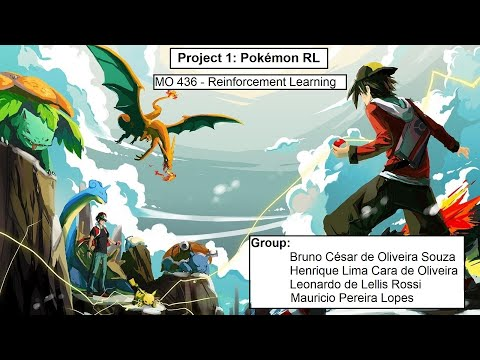

In [82]:
from IPython.display import YouTubeVideo

YouTubeVideo('_XtuvAax4fs', width=960, height=540)

# Discussion


Differently from the works found in the literature, which train and validate their models only against a RandomPlayer, our methods were trained against a MaxDamagePlayer and validated against a MaxDamagePlayer and against a RandomPlayer, showing significant improvements. All of our implemented methods showed better results than a RandomPlayer with the same battle configurations.

Our Monte-Carlo Control 1st Visit agent, in a stochastic environment, averaged $34.91\%$ wins against a MaxDamagePlayer and $92.7\%$ wins against a RandomPlayer. In a deterministic environment, the agent averaged $39.4\%$ wins against a MaxDamagePlayer and $90.57\%$ wins against a RandomPlayer. In a visual analysis of the battles, we noticed that the agent promoted switches to better type Pokémon, to not suffer super-effective attacks, and to Pokémon with super-effective attacks against the opponent. Compared to the other implemented methods, the agent with Monte-Carlo was the one with the worst performance against MaxDamagePlayer. We hypothesize that this occurs because Monte-Carlo methods occur through sampling, acquiring the rewards and updating their tables only at the end of each episode. In a battle against MaxDamagePlayer, this can demonstrate a negative performance, as MaxDamagePlayer always selects attacks with the highest Base Power, which can cause the end of a battle very quickly, making it difficult for the agent to define the best strategy. This lack of bootstrapping, however, allows the method to have a good convergence, performing well against a RandomPlayer.


Our Monte-Carlo Control 1st Visit with Function Approximation agent, in a stochastic environment, averaged $83.46\%$ wins against a MaxDamagePlayer (improving by $48.55\%$ compared to the agent without Function Approximation) and $92.7\%$ wins against a RandomPlayer (improving by $6.52\%$ compared to the agent without Function Approximation). In a deterministic environment, the agent averaged $60.05\%$ (improving by $20.64\%$ compared to the agent without Function Approximation) wins against a MaxDamagePlayer and $99.29\%$ wins against a RandomPlayer (improving by $8.72\%$ compared to the agent without Function Approximation). We noticed that our Feature Vector performed very well in generalizing our states (out of $1,016,064$ possible states). As in the method without Function Approximation, in a visual analysis of the battles, we noticed that the agent promoted switches to better type Pokémon, to not suffer super-effective attacks, and to Pokémon with super-effective attacks against the opponent. 


Our Q-Learning agent, in a stochastic environment, averaged $41.69\%$ wins against a MaxDamagePlayer and $90.04\%$ wins against a RandomPlayer. In a deterministic environment, the agent averaged $39.84\%$ wins against a MaxDamagePlayer and $85.36\%$ wins against a RandomPlayer. In a visual analysis of the battles, as previous methods, we noticed that the agent promoted switches to better type Pokémon, to not suffer super-effective attacks, and to Pokémon with super-effective attacks against the opponent. In addition, the agent made good use of Pokémon abilities to lower the opponent's attack stat. The agent also used Roost (recover Health Points) and Sleep Powder (cause status to the opponent) several times. This is because our rewards have parameters in these cases (HP value and opponent's status). As Q-Learning looks for the best reward in each state, the agent took advantage of the execution of these moves to maximize its rewards.

Our Q-Learning with Function Approximation agent, in a stochastic environment, averaged $83.84\%$ wins against a MaxDamagePlayer (improving by $42.15\%$ compared to the agent without Function Approximation) and $99.22\%$ wins against a RandomPlayer (improving by $9.18\%$ compared to the agent without Function Approximation). In a deterministic environment, the agent averaged $58.73\%$ wins against a MaxDamagePlayer (improving by $18.89\%$ compared to the agent without Function Approximation) and $99.34\%$ wins against a RandomPlayer (improving by $13.98\%$ compared to the agent without Function Approximation), being the agent that showed the best performance in an average of all executed battles. This demonstrates again that our Feature Vector performed very well in generalizing our states. Furthermore, we hypothesize that, as Q-Learning has bootstrapping, it was able to generalize well the seen states in order to maximize their rewards. In a visual analysis of the battles, as previous methods, we noticed that the agent promoted switches to Pokémon with super-effective attacks against the opponent. Also, the agent made a lot of use of the Giga Drain damage move (promotes damage and recovers HP), even when this move wasn't very effective. We hypothesize that this occurs because the Player realized that, even if the move was not very effective, it promoted a decrease in the opponent's Health Points and an increase in ours, promoting greater rewards.

Our SARSA($\lambda$) agent, in a stochastic environment, averaged $54.79\%$ wins against a MaxDamagePlayer and $90.94\%$ wins against a RandomPlayer. In a deterministic environment, the agent averaged $52.93\%$ wins against a MaxDamagePlayer and $99.34\%$ wins against a RandomPlayer, being the best performing tabular method against MaxDamagePlayer. In a visual analysis of the battles, the agent made a lot of use of non-damage move Leech Seed, which removes the opponent's Health Points in each battle and adds them to ours. This is because our rewards have parameters in these cases (+ our HP and - opponent's HP). The agent also used the non-damage move Sunny Day when the opponent was with a Water-type Pokémon, causing the attacks of this opposing Pokémon to decrease its Base Power. As requested in the project specification, we use the same step-size and exploration schedules as the Monte-Carlo method. For this, the same base class was used in both agents.

Our SARSA($\lambda$) with Function Approximation agent, in a stochastic environment, averaged $83.46\%$ wins against a MaxDamagePlayer (improving by $28.67\%$ compared to the agent without Function Approximation) and  $61.21\%$ wins against a RandomPlayer (decreasing by $33.63\%$ compared to the agent without Function Approximation, being the only case where a method with Function Approximation performed worse than the method without Function Approximation). We hypothesized that this happened because, as SARSA($\lambda$) is bootstrapped, the method may have become biased due to the training being done against a MaxDamagePlayer, and thus, our Feature Vector was not sufficient to generalize well with a RandomPlayer. Also, as the environment is stochastic, it's possible that our Player missed the attacks. In a deterministic environment, the agent averaged $61.21\%$ wins against a MaxDamagePlayer (improving by $8.28\%$ compared to the agent without Function Approximation) and $99.13\%$ wins against a RandomPlayer (improving by $9.65\%$ compared to the agent without Function Approximation). The good performance of the agent in a deterministic environment in relation to the method without Function Approximation corroborates our hypothesis that our agent may have missed attacks due to the randomity of the stochastic environment. In a visual analysis of the battles, as previous methods, we noticed that the agent promoted switches to Pokémon with super-effective attacks against the opponent. Also, the agent made a lot of use of the Giga Drain damage move (promotes damage and recovers HP), even when this move wasn't very effective.

# Conclusion

Given the complexity of a Pokémon battle (as shown, $1,016,064$ states and $9,144,576$ possibilities), the implemented methods were able to generalize the states and explore the best reward acquisitions, with all methods performing better than a RandomPlayer. The methods showed increasing learning, in view of the increase in rewards and victory rate as battles went on.

Particularly, the methods that used Function Approximation found it easier to generalize the states, given the influence of our Features Vector, since the tabular methods find it difficult to generalize the millions of possibilities in a few battles ($10k$).

In addition to the difference in training and validating using a MaxDamagePlayer (getting good results), most of our methods presented better performances than related works.

As future work, we propose the exploration of specific parameters for each method. Following the guidelines of the project specifications, the same parameters defined for Monte-Carlo Control were used. However, some methods can take better advantage of other parameters, such as SARSA($\lambda$), which is very dependent on the value set for $\lambda$.

# Contributions

## Methods

### Monte Carlo Control
* **Code development**: Leonardo;
* **Code review**: Bruno, Henrique, Maurício;
* **Experiments**: Leonardo.

### Monte Carlo Control Function Approximation
* **Code development**: Leonardo;
* **Code review**: Bruno, Henrique, Maurício;
* **Experiments**: Leonardo.

### Q-Learning
* **Code development**: Henrique;
* **Code review**: Bruno, Leonardo, Maurício;
* **Experiments**: Henrique, Leonardo.

### Q-Learning Function Approximation
* **Code development**: Henrique;
* **Code review**: Bruno, Leonardo, Maurício;
* **Experiments**: Henrique.

### SARSA($\lambda$)
* **Code development**: Bruno;
* **Code review**: Leonardo, Maurício;
* **Experiments**: Bruno, Leonardo, Maurício.

### SARSA($\lambda$) Function Approximation
* **Code development**: Bruno;
* **Code review**: Leonardo, Maurício;
* **Experiments**: Bruno, Leonardo, Maurício.

## Video
* **Editing**: Leonardo;
* **Review**: Bruno, Henrique, Maurício.

## Report
* **Writting**: Bruno, Henrique, Leonardo, Maurício.
